# Anchor Testing

Experimenting with anchor and bounding-box definitions, in the same manner as SSD networks.

Also trying to optimize time to generate all coordinates.

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if __name__ == '__main__':


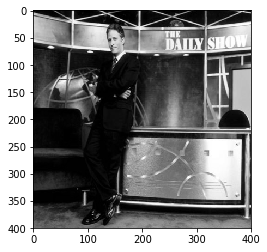

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from scipy.misc import imresize

image = np.asarray(Image.open('DailyShow.jpg').convert('L'))
new_dim = min(image.shape[0], image.shape[1])
image = imresize(image, (new_dim, new_dim))

plt.gray()

plt.imshow(image)
plt.show()

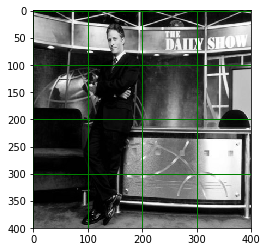

In [3]:
from math import sqrt

grid_squares = 16
w,h = image.shape
grid_w = int(w/(sqrt(grid_squares)))
grid_h = int(h/(sqrt(grid_squares)))

from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1)
ax.imshow(image)

for x in range(grid_w):
    for y in range(grid_h):
        rectangle = Rectangle((x*grid_w,y*grid_w),grid_w,grid_h, edgecolor='g', fill=False)
        ax.add_patch(rectangle)
        
plt.show()

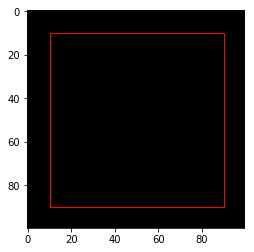

In [4]:
size = 100
reference_grid = np.zeros(shape=(size,size))
centerpoint = (int(size/2), int(size/2))

# define some box sizes & w/h ratios. Only need 2 numbers
example_box_height = 0.8 # on a range from 0 to 1
example_box_width = 0.8

# need a way of checking that these two values don't span past their space
assert(example_box_height*example_box_width <= 1.0)

example_box_width *= size
example_box_height *= size

box = Rectangle((centerpoint[0]-int(example_box_width/2), centerpoint[1]-int(example_box_height/2)), example_box_width, example_box_height, edgecolor='r', fill=False)

fig, ax = plt.subplots(1)
ax.imshow(reference_grid)
ax.add_patch(box)
plt.show()

In [97]:
# a few more tuples of (height, whratio)
boxes = [(.9,.9), (.9,.5), (.9,.2), (.2,.9), (.5,.9)]

In [94]:
# taking the approach above and creating a general function
def create_grid_boxes(grid_x, grid_y, grid_size):
    grid_boxes = []
    for (w,h) in (boxes):
        assert w*h <= 1.0
        w *= grid_size
        h *= grid_size
        # want to return the top left and bottom right coordinates wrt grid spot
        centerpoint = (int((grid_x + grid_size)/2), int((grid_y + grid_size)/2))
        top_left = (centerpoint[0]-int(w/2), centerpoint[1]-int(h/2))
        bot_right = (centerpoint[0]+int(w/2), centerpoint[1]+int(h/2))
        grid_boxes.append((top_left, bot_right))
    return grid_boxes

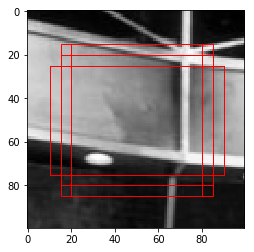

In [96]:
# Looking at the first patch in 'image'

# TODO: if the images are square, we only really need a variable for grid_w
grid = image[0:grid_w, 0:grid_h]

grid_boxes = create_grid_boxes(0, 0, grid_w)

fig, ax = plt.subplots(1)
ax.imshow(grid)
for (top_left, bot_right) in (grid_boxes):
    w = bot_right[0] - top_left[0]
    h = bot_right[1] - top_left[1]
    box_rect = Rectangle((top_left), w, h, edgecolor='r', fill=False)
    ax.add_patch(box_rect)
plt.show()

In [86]:
# Now doing this over the entire 'image'

def create_image_boxes(image, grid_squares):
    w,h = image.shape
    # resize to a square image
    new_dim = min(w,h)
    imresize(image, (new_dim, new_dim))
    
    grid_size = int(new_dim/sqrt(grid_squares))
    
    image_boxes = []
    
    for x in range(int(sqrt(grid_size))):
        for y in range(int(sqrt(grid_size))):
            image_boxes.append(create_grid_boxes(2*x*grid_size, 2*y*grid_size, grid_size))

    return image_boxes

Generating... Grid Squares: 1


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  import sys


Generating... Grid Squares: 4
Generating... Grid Squares: 16
Generating... Grid Squares: 64
Generating... Grid Squares: 256


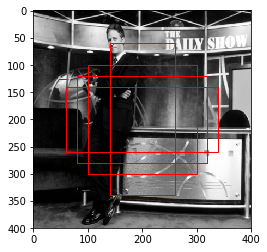

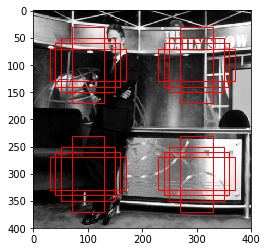

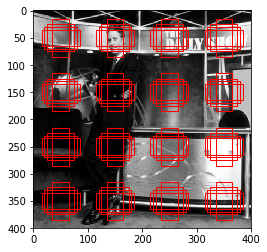

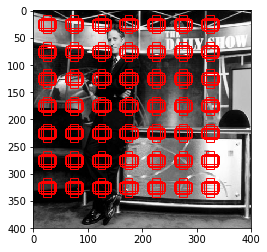

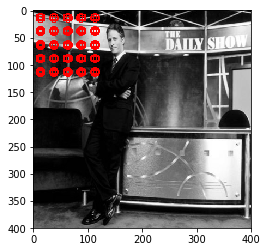

In [87]:
# Now we can test how this looks while changing the number of grid spaces

grid_squares = 1

for i in range(5):
    print("Generating... Grid Squares: " + str(grid_squares))
    image_boxes = create_image_boxes(image, grid_squares)
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for grid_boxes in image_boxes:
        for (top_left, bot_right) in grid_boxes:
            w = bot_right[0] - top_left[0]
            h = bot_right[1] - top_left[1]
            box_rect = Rectangle((top_left), w, h, edgecolor='r', fill=False)
            ax.add_patch(box_rect)
    grid_squares *= 4
    
plt.show()

Unfortunately this takes an incredibly long time to generate. The next goal is to recreate the above methods and arrays with a parallel approach, either with NumPy or Tensorflow.

To confirm that this takes too long, I've redone the above steps without plotting, below:

In [88]:
import time

init = time.time()

image_boxes = []

for i in range(5):
    image_boxes.append(create_image_boxes(image, grid_squares))
    
print(time.time() - init)

0.010926008224487305


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  import sys


In [98]:
# NumPy implementation

def create_grid_boxes(grid_x, grid_y, grid_size):
    grid_boxes = np.ndarray(shape=(len(boxes),4), dtype=int)
    for i in range(len(boxes)):
        w,h = boxes[i]
        assert w*h <= 1.0
        w *= grid_size
        h *= grid_size
        # want to return the top left and bottom right coordinates wrt grid spot
        centerpoint = (int((grid_x + grid_size)/2), int((grid_y + grid_size)/2))
        top_left = (centerpoint[0]-int(w/2), centerpoint[1]-int(h/2))
        bot_right = (centerpoint[0]+int(w/2), centerpoint[1]+int(h/2))
        grid_boxes[i][0] = top_left[0]
        grid_boxes[i][1] = top_left[1]
        grid_boxes[i][2] = bot_right[0]
        grid_boxes[i][3] = bot_right[1]
    return grid_boxes
   
# Here I am going to go ahead and assume that 'image' is square

def create_image_boxes(image, grid_squares):
    w = image.shape[0]
    grid_size = int(w/sqrt(grid_squares))
    image_boxes = np.ndarray(shape=(len(boxes)*grid_squares, 4), dtype=int)
    i = 0
    for x in range(int(sqrt(grid_squares))):
        for y in range(int(sqrt(grid_squares))):
            image_boxes[i:i+len(boxes)] = create_grid_boxes(2*x*grid_size, 2*y*grid_size, grid_size)
            i += len(boxes)
    return image_boxes

One thing to note is how many lists/arrays are created, which is likely using a lot of memory.

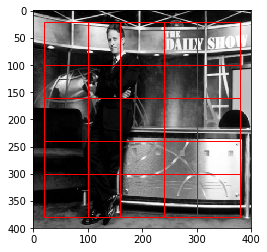

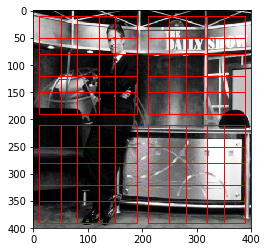

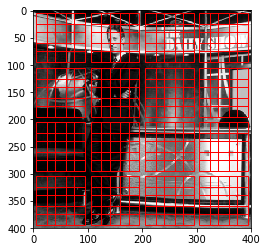

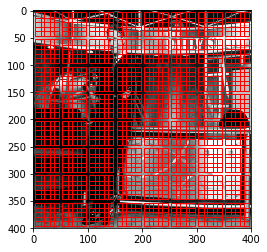

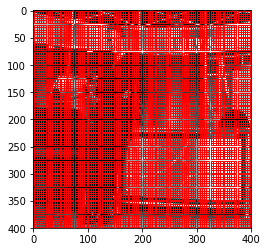

In [99]:
grid_squares = 1

for i in range(5):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for (x1, y1, x2, y2) in (create_image_boxes(image, grid_squares)):
        rect = Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='r', fill=False)
        ax.add_patch(rect)
    grid_squares*=4 
    
plt.show()

In [103]:
init = time.time()

grid_squares = 1

all_boxes = create_image_boxes(image, grid_squares)

for i in range(1, 4):
    grid_squares *= 4
    all_boxes = np.concatenate((all_boxes, create_image_boxes(image, grid_squares)))#, axis=1)

print(time.time() - init)

0.006972789764404297


As we can see, the NumPy implementation is faster.

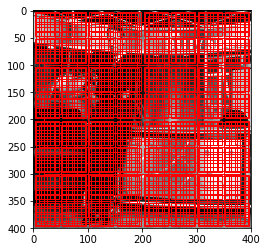

[[ 20  20 380 380]
 [ 20 100 380 300]
 [ 20 160 380 240]
 ...
 [353 370 397 380]
 [370 353 380 397]
 [363 353 387 397]]


In [104]:
# All boxes imposed on image

fig, ax = plt.subplots(1)
ax.imshow(image)
for (x1, y1, x2, y2) in (all_boxes):
    rect = Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='r', fill=False)
    ax.add_patch(rect)

plt.show()

print(all_boxes)

In [105]:
print(all_boxes.shape)

(425, 4)
